## ICESat-2 SlideRule Download

This code is adapted from Sliderule Python example code. It is designed to calculate ATL06 elevations from ALT03 points and save those elevations as a CSV. 

Activate the sliderule_env enviroment to run

Last updated by Karina Zikan July 2023

In [26]:
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5

## SlideRule Configuration

In [27]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io", verbose=False)

## Specify Region of Interest

#### 1. Make geojson from shapefile - if you have a geojson of the region skip to 2.

In [28]:
# Specify region of interest shapefile
shp = "/Users/titus/BSU/remote_sensing/carbon_estimation/shapefiles/RCEW-outline_WGS84.shp"
shapefile = gpd.read_file(shp)
# shapefile.to_file('/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/boundDCEW_WGS84.geojson', driver='GeoJSON')
shapefile.crs is None

False

##### - Check shapefile crs

In [29]:
## if shapefile.crs is None is false check the crs
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

##### - Make Geojson

In [30]:
# shapefile.to_file('/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/RCEW-outline_WGS84.geojson', driver='GeoJSON')

In [31]:
## if shapefile.crs is None is true run this section
#crs = 'epsg:8826' # set the starting datum using the epsg code
#icesat_crs = 4979 # epsg code for WGS84
#shapefile = shapefile.set_crs(crs)
#shapefile = shapefile.to_crs(icesat_crs) # transform to WGS84 
#shapefile.to_file('/Mores/MCSboundary/MoresBound_WGS84.geojson', driver='GeoJSON')

In [32]:
## if shapefile.crs is not WGS84 run this section
#icesat_crs = 4979 # epsg code for WGS84
#shapefile = shapefile.to_crs(icesat_crs) # transform to WGS84 
#shapefile.to_file('/Mores/MCSboundary/MoresBound_WGS84.geojson', driver='GeoJSON')

#### 2. Read in geojson for Region of Interest

In [33]:
# Specify region of interest from geojson
poly_fn = '/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/RCEW-outline_WGS84.geojson'
region = sliderule.toregion(poly_fn)["poly"] # symplify 
region
# poly_fn

[{'lon': -116.799, 'lat': 43.06089},
 {'lon': -116.7954, 'lat': 43.06089},
 {'lon': -116.7481, 'lat': 43.06268},
 {'lon': -116.747, 'lat': 43.06295},
 {'lon': -116.7411, 'lat': 43.06456},
 {'lon': -116.7409, 'lat': 43.06469},
 {'lon': -116.7392, 'lat': 43.06591},
 {'lon': -116.7379, 'lat': 43.06712},
 {'lon': -116.7179, 'lat': 43.09706},
 {'lon': -116.7008, 'lat': 43.12889},
 {'lon': -116.6963, 'lat': 43.13834},
 {'lon': -116.696, 'lat': 43.13915},
 {'lon': -116.6922, 'lat': 43.15454},
 {'lon': -116.6881, 'lat': 43.22341},
 {'lon': -116.6881, 'lat': 43.22476},
 {'lon': -116.6947, 'lat': 43.24693},
 {'lon': -116.6954, 'lat': 43.24828},
 {'lon': -116.6958, 'lat': 43.24883},
 {'lon': -116.702, 'lat': 43.2564},
 {'lon': -116.7022, 'lat': 43.25654},
 {'lon': -116.7579, 'lat': 43.2872},
 {'lon': -116.7605, 'lat': 43.28828},
 {'lon': -116.7612, 'lat': 43.28856},
 {'lon': -116.8199, 'lat': 43.31163},
 {'lon': -116.8251, 'lat': 43.31298},
 {'lon': -116.8266, 'lat': 43.31218},
 {'lon': -116.8303

In [34]:
# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]
region_lon
# print(region_lat)
gg = []
for i in range(len(region_lon)):
    gg.append((region_lat[i], region_lon[i]))
    
gg

[(43.06089, -116.799),
 (43.06089, -116.7954),
 (43.06268, -116.7481),
 (43.06295, -116.747),
 (43.06456, -116.7411),
 (43.06469, -116.7409),
 (43.06591, -116.7392),
 (43.06712, -116.7379),
 (43.09706, -116.7179),
 (43.12889, -116.7008),
 (43.13834, -116.6963),
 (43.13915, -116.696),
 (43.15454, -116.6922),
 (43.22341, -116.6881),
 (43.22476, -116.6881),
 (43.24693, -116.6947),
 (43.24828, -116.6954),
 (43.24883, -116.6958),
 (43.2564, -116.702),
 (43.25654, -116.7022),
 (43.2872, -116.7579),
 (43.28828, -116.7605),
 (43.28856, -116.7612),
 (43.31163, -116.8199),
 (43.31298, -116.8251),
 (43.31218, -116.8266),
 (43.31002, -116.8303),
 (43.30989, -116.8305),
 (43.29223, -116.8559),
 (43.29209, -116.8561),
 (43.29182, -116.8564),
 (43.26859, -116.8594),
 (43.2151, -116.8574),
 (43.20781, -116.8563),
 (43.08162, -116.8363),
 (43.07946, -116.8341),
 (43.07783, -116.8319),
 (43.07769, -116.8317),
 (43.07539, -116.8282),
 (43.07526, -116.828),
 (43.06089, -116.799)]

In [35]:
# from ipyleaflet import Map, Polygon

# polygon = Polygon(
#     locations=gg,
#     color="green",
#     fill_color="green"
# )

# m = Map(center=(43.17, -116.51), zoom=9)
# m.add(polygon);

# m

<Figure size 800x1200 with 0 Axes>

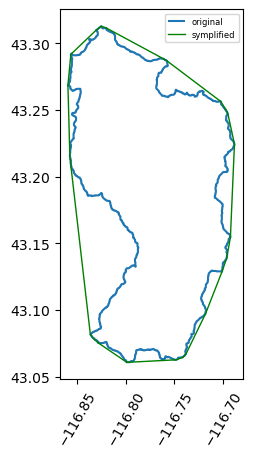

In [36]:
# Read geojson with geopandas
plt.figure(figsize=(8,12))
pregion = gpd.read_file(poly_fn)
map = pregion.plot(label = "original"); # plot origonal boundery 
map.plot(region_lon, region_lat, linewidth=1, color='g', label = "symplified"); # plot symplified region boundary for a sanity check
plt.legend(fontsize=6, loc="upper right")
plt.xticks(rotation=60)
plt.show()

#### 3. Save simplified polygon

In [37]:
polygon_geom = Polygon(zip(region_lon, region_lat))
crs = 'epsg:4979'
polygon = gpd.GeoDataFrame(index=[0], geometry=[polygon_geom])       

polygon

,geometry
0,"POLYGON ((-116.799 43.06089, -116.7954 43.0608..."


### Save to file if you haven't already

In [38]:
# polygon.to_file('/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/RCEW-outline_WGS84_simple.geojson', driver='GeoJSON')

# Sliderule Product processing

Follow the processing section for the desired product

### - ATL08 and ATL08_classified processing 

Choose ATL08 or ATL08_clssified parameters depending on what product you are downloading

#### ATL08 Parameters

In [60]:
parms = {
    "poly": region, # polygon defining region of interest 
    "srt": 0, # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    # "atl08_class": "atl08_ground", # list of ATL08 classifications used to select which photons are used in the processing (the available classifications are: “atl08_noise”, “atl08_ground”, “atl08_canopy”, “atl08_top_of_canopy”, “atl08_unclassified”)
    "cnf": icesat2.CNF_BACKGROUND, #0, # icesat2.CNF_SURFACE_HIGH, # confidence level for photon selection, can be supplied as a single value or a list
    "ats": 20.0, # minimum along track spread
    "cnt": 10, # minimum photon count in segment
    "len": 40.0, # length of each extent in meters
    "res": 20.0, # step distance for successive extents in meters
    "maxi": 6, # maximum iterations, not including initial least-squares-fit selection
    "atl03_ph_fields": ["pce_mframe_cnt"],
    "atl03_geo_fields": ["solar_elevation"],
    "atl08_fields": ["asr%"],
    "t0": '2021-05-01T00:00:00Z',
    "t1": '2021-07-31T00:00:00Z',
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"], #the photon’s ATL08 classification (0: noise, 1: ground, 2: canopy, 3: top of canopy, 4: unclassified)
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0)
}

# parms = {
#     "poly": region, # polygon defining region of interest 
#     "srt": 0, # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
#     "atl08_class": "atl08_ground", #list of ATL08 classifications used to select which photons are used in the processing (the available classifications are: “atl08_noise”, “atl08_ground”, “atl08_canopy”, “atl08_top_of_canopy”, “atl08_unclassified”)
#     "cnf": 0 # icesat2.CNF_SURFACE_HIGH, # confidence level for photon selection, can be supplied as a single value or a list
#     "ats": 10.0, # minimum along track spread
#     "cnt": 5, # minimum photon count in segment
#     "len": 20.0, # length of each extent in meters
#     "res": 20.0, # step distance for successive extents in meters
#     "maxi": 6, # maximum iterations, not including initial least-squares-fit selection
#     "atl03_ph_fields": ["pce_mframe_cnt"],
#     "atl03_geo_fields": ["solar_elevation"],
#     "atl08_fields": ["asr"]
# }

cvs_name = "/Users/titus/BSU/remote_sensing/carbon_estimation/data/icesat2_data/rcew_icesat2_atl08sr_may21_jul21.csv" #set name of the output

#### ATL08_classified Parameters

In [61]:
# parms = {
#     "poly": region,
#     "srt": 0,
#     "atl08_class": "atl08_ground", # list of ATL08 classifications used to select which photons are used in the processing (the available classifications are: “atl08_noise”, “atl08_ground”, “atl08_canopy”, “atl08_top_of_canopy”, “atl08_unclassified”)
#     "cnf": 0, # icesat2.CNF_BACKGROUND, 
#     "ats": 20.0,
#     "cnt": 10,
#     "len": 40.0,
#     "res": 20.0,
#     "maxi": 6,
#     "atl03_ph_fields": ["pce_mframe_cnt"],
#     "atl03_geo_fields": ["solar_elevation"],
#     "atl08_fields": ["asr"]
# }
# cvs_name = "/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/RCEW-ICESat2-ATL08sr-atl08class.csv" #set name of the output

#### Calculate Elevations

In [62]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL08 Data
data = icesat2.atl08p(parm=parms, keep_id=True)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
#print("Reference Ground Tracks: {}".format(atl08_sr["rgt"].unique()))
#print("Cycles: {}".format(atl08_sr["cycle"].unique()))
print("Received {} elevations".format(data.shape[0]))

Completed in 4.918 seconds of wall-clock time
Received 15915 elevations


## Plot ATL08 Results 

/var/folders/fx/2fdk1gcs15x1chhn56kqjpl40000gp/T/ipykernel_3362/3873127791.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, loc="upper right")


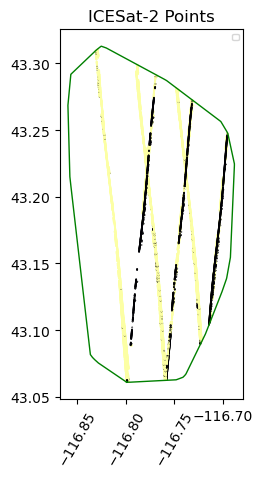

In [63]:
f, ax = plt.subplots()
ax.set_title("ICESat-2 Points")
ax.set_aspect('equal')
data.plot(ax=ax, column='h_mean_canopy', cmap='inferno', s=0.1)
ax.plot(region_lon, region_lat, linewidth=1, color='g');
plt.legend(fontsize=6, loc="upper right")
plt.xticks(rotation=60)
plt.show()

## Data Check

In [64]:
# type(data)
data.columns

Index(['cycle', 'gnd_ph_count', 'gt', 'extent_id', 'spot', 'solar_elevation_x',
       'h_max_canopy', 'rgt', 'h_mean_canopy', 'h_min_canopy', 'landcover',
       'x_atc', 'snowcover', 'veg_ph_count', 'ph_count', 'h_canopy',
       'canopy_h_metrics', 'canopy_openness', 'h_te_median', 'segment_id',
       'geometry', 'pce_mframe_cnt', 'solar_elevation_y', 'asr%'],
      dtype='object')

In [65]:
#Set utmzone code - utm zone 11:32611
utm_code = 'epsg:32611' 

data['Longitude'] = data['geometry'].x
data['Latitude'] = data['geometry'].y
eastnorths = data['geometry'].to_crs(utm_code)
data['Easting'] = eastnorths.x
data['Northing'] = eastnorths.y
data

,cycle,gnd_ph_count,gt,extent_id,spot,solar_elevation_x,h_max_canopy,rgt,h_mean_canopy,h_min_canopy,...,h_te_median,segment_id,geometry,pce_mframe_cnt,solar_elevation_y,asr%,Longitude,Latitude,Easting,Northing
time,,,,,,,,,,,,,,,,,,,,,
2021-05-23 01:47:15.204737536,11,0,30,4075758429421961218,4,13.351813,9.183409e-41,905,9.183269e-41,-6.581233e-10,...,-2.420784e-28,239030,POINT (-116.75768 43.06258),1341452613,13.351835,0.0,-116.757680,43.062577,519732.309206,4.767792e+06
2021-05-23 01:47:15.207337472,11,0,30,4075758429421961222,4,13.351813,9.183409e-41,905,9.183269e-41,-6.581233e-10,...,-2.420784e-28,239031,POINT (-116.75757 43.06273),1341452613,13.351870,0.0,-116.757574,43.062734,519740.925089,4.767809e+06
2021-05-23 01:47:15.209987456,11,0,30,4075758429421961226,4,13.351858,9.183409e-41,905,9.183269e-41,-6.581233e-10,...,-2.420784e-28,239032,POINT (-116.75767 43.06291),1341452613,13.351930,0.0,-116.757669,43.062910,519733.126621,4.767829e+06
2021-05-23 01:47:15.212937472,11,0,30,4075758429421961230,4,13.351891,9.183409e-41,905,9.183269e-41,-6.581233e-10,...,-2.420784e-28,239033,POINT (-116.75769 43.0631),1341452613,13.352001,0.0,-116.757692,43.063098,519731.191605,4.767850e+06
2021-05-23 01:47:15.215637504,11,0,30,4075758429421961234,4,13.351989,9.183409e-41,905,9.183269e-41,-6.581233e-10,...,-2.420784e-28,239034,POINT (-116.75775 43.06327),1341452613,13.352049,0.0,-116.757754,43.063274,519726.055631,4.767869e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26 10:58:40.405612544,12,0,60,2256304266937373687,1,-14.510273,0.000000e+00,501,0.000000e+00,0.000000e+00,...,0.000000e+00,762765,POINT (-116.79865 43.06191),3260108448,-14.510353,0.0,-116.798647,43.061915,516396.714523,4.767710e+06
2021-07-26 10:58:40.409162496,12,0,60,2256304266937373691,1,-14.510433,0.000000e+00,501,0.000000e+00,0.000000e+00,...,0.000000e+00,762766,POINT (-116.79868 43.06169),3260108448,-14.510498,0.0,-116.798684,43.061689,516393.798527,4.767684e+06
2021-07-26 10:58:40.410612480,12,0,60,2256304266937373695,1,-14.510539,0.000000e+00,501,0.000000e+00,0.000000e+00,...,0.000000e+00,762767,POINT (-116.7987 43.0616),3260108448,-14.510564,0.0,-116.798698,43.061597,516392.624064,4.767674e+06


## Write to csv - ATL08

In [20]:
# import datetime 
# data['Date'] = pd.to_datetime(data.index)
# data = data[(data['Date'].dt.month >= 5) & (data['Date'].dt.month <= 9)]
# data[1:6]

In [ ]:
# cvs_name = "/Users/titus/BSU/remote_sensing/carbon_estimation/data/icesat2_data/rcew_icesat2_atl08sr_may21_jul21_new2.csv" #set name of the output
# data.to_csv(cvs_name)

## Write to geojson

In [ ]:
# outName = cvs_name.replace('.csv', '.geojson')  # Create an output file name using the input file name
# outName

'/Users/titus/BSU/remote_sensing/carbon_estimation/data/icesat2_data/rcew_icesat2_atl08sr_may21_jul21_new2.geojson'

In [ ]:
# data.to_file(outName, driver='GeoJSON')  # Export to GeoJSON